In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
#%run ../../core/resolution.py
# gather all ingredients and save them as unified 'mephistogram' data structure
#%run ../../core/prepare_histograms.py

In [3]:
import mkl
mkl.set_num_threads(1)

48

In [4]:
import numpy as np
from glob import glob
from tools import ang_dist
from settings import *

import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from tools import array_source_interp
from likelihood import poisson_llh, ps_llh_single
from tqdm import tqdm
import settings as st


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Real data

In [5]:
# 10yr data release
# we take only the full detector configurations >= IC86-II,
# because these we also took for the resolutions and effective area
all_data = []
for fn in glob(join(LOCALPATH, "icecube_10year_ps/events/IC*.csv")):
    #if "_I_" in fn: continue
    print(fn)
    all_data.extend(np.genfromtxt(fn, names=True))
all_data = np.array(all_data)


/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_III_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_VII_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_V_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_II_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC79_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_I_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC59_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC40_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_IV_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_VI_exp.csv


In [6]:
# 10yr data release
# we take only the full detector configurations >= IC86-II,
# because these we also took for the resolutions and effective area
exp_data = []
for fn in glob(join(LOCALPATH, "icecube_10year_ps/events/IC86*.csv")):
    if "_I_" in fn: continue
    print(fn)
    exp_data.extend(np.genfromtxt(fn, names=True))
exp_data = np.array(exp_data)


/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_III_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_VII_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_V_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_II_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_IV_exp.csv
/home/hpc/capn/capn102h/repos/Plenum/local/icecube_10year_ps/events/IC86_VI_exp.csv


In [7]:
len(all_data), len(exp_data), len(exp_data)/len(all_data)

(1134450, 761162, 0.6709524439155538)

In [8]:
angular_distances = np.rad2deg(
    ang_dist(
        ngc1068.ra.rad,
        ngc1068.dec.rad,
        np.deg2rad(exp_data["RAdeg"]),
        np.deg2rad(exp_data["Decdeg"]),
    )
)[0]


# select events within the analysis window
ngc_dist_mask = angular_distances <= delta_psi_max
ngc_events = exp_data[ngc_dist_mask]
ngc_angular_distances = angular_distances[ngc_dist_mask]

# select events in declination band
dec_distances = np.rad2deg(
    ang_dist(
        0,
        ngc1068.dec.rad,
        np.zeros_like(exp_data["RAdeg"]),
        np.deg2rad(exp_data["Decdeg"]),
    )
)[0]

ngc_dec_mask = ~ngc_dist_mask & (dec_distances <= delta_psi_max)
ngc_dec_events = exp_data[ngc_dec_mask]
ngc_dec_distances = dec_distances[ngc_dec_mask]

In [9]:
# ngc1068 data release
# new_ev = pd.read_csv("/home/lisajsch/Downloads/20220913_Evidence_for_neutrino_emission_from_the_nearby_active_galaxy_NGC_1068_data/ps_data_release/resources/event_list.txt")

Text(0, 0.5, 'dec/deg')

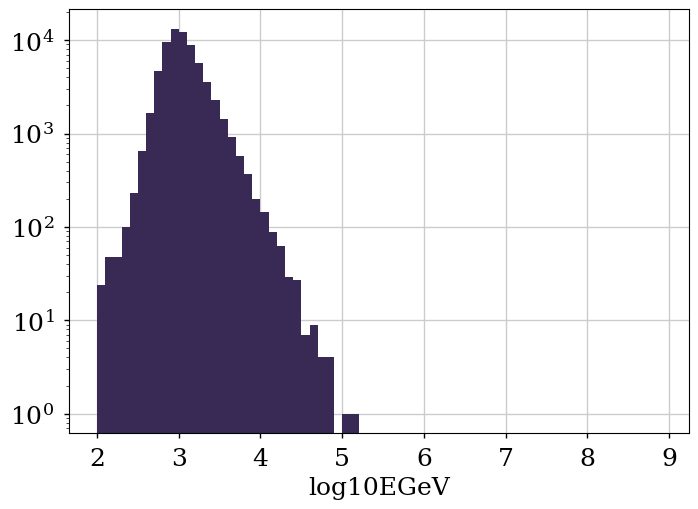

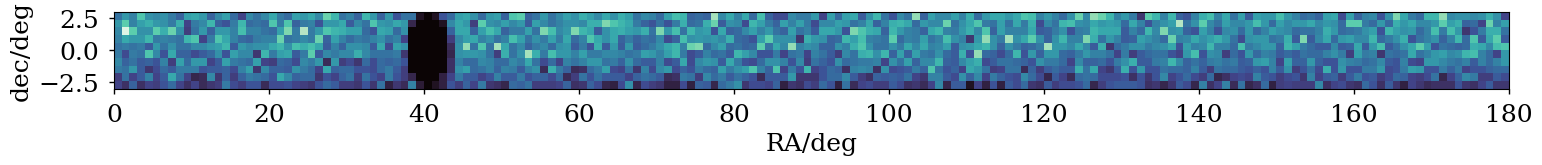

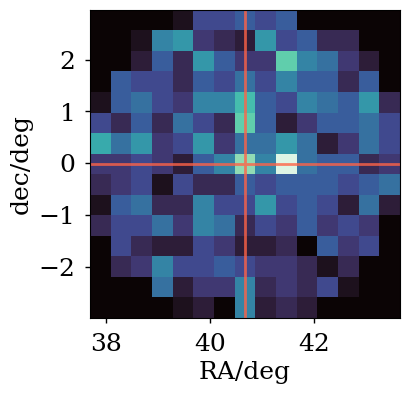

In [10]:
plt.figure()
plt.hist(ngc_dec_events["log10EGeV"], bins=logE_reco_bins[::2])
plt.yscale("log")
plt.xlabel("log10EGeV")

plt.figure(figsize=(18, 1))
_ = plt.hist2d(ngc_dec_events["RAdeg"], ngc_dec_events["Decdeg"], bins=(360, 10))
plt.xlabel("RA/deg")
plt.ylabel("dec/deg")
plt.xlim(0, 180)

plt.figure(figsize=(4, 4))
_ = plt.hist2d(ngc_events["RAdeg"], ngc_events["Decdeg"], bins=15)
plt.scatter(
    ngc1068.ra.deg, ngc1068.dec.deg, color="tomato", marker="+", s=1E5, alpha=0.8
)
plt.xlabel("RA/deg")
plt.ylabel("dec/deg")


For the sake of simplicity, we use the effective area and resolution functions of only IC86. Further updates will see the "per detector config" PDFs. Much of the discrepancy is mitigated by using data itself to describe the background PDF of reconstructed energy.

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [11]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

# Atmospheric background

In [12]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))


Elementary arithmetic possible.
True


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [13]:
with open(join(LOCALPATH, "GP_Eres_mephistograms.pckl"), "rb") as f: #
    all_eres = pickle.load(f)
# select only horizontal resolution for NGC 1068 at horizon
baseline_eres = all_eres['dec-0.0']
baseline_eres.normalize(axis=1) # normalize per logE_true


In [14]:
all_eres.keys()

dict_keys(['dec--50.0', 'dec-0.0', 'dec-50.0'])

Text(0.5, 1.0, 'dec--50.0')

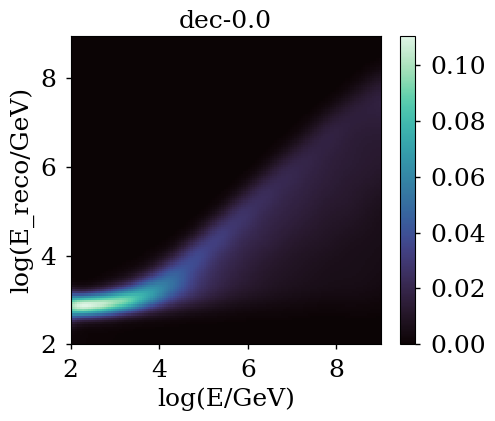

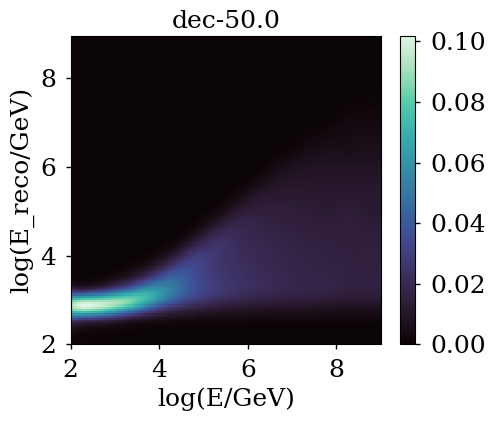

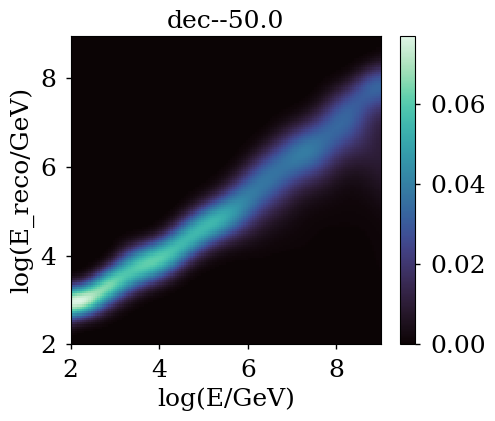

In [15]:
all_eres['dec-0.0'].plot()
plt.gca().set_title('dec-0.0')
all_eres['dec-50.0'].plot()
plt.gca().set_title('dec-50.0')
all_eres['dec--50.0'].plot()
plt.gca().set_title('dec--50.0')


In [16]:
from resolution import read_smearing_matrix

In [17]:
4 * np.deg2rad(40) * np.deg2rad(10) / (4 * np.pi) * 59592

2311.281350774357

In [18]:
public_data_df = read_smearing_matrix()
log_sm_emids = (public_data_df["logE_nu_min"] + public_data_df["logE_nu_max"]) / 2.0
log_sm_ereco_mids = (public_data_df["logE_reco_min"] + public_data_df["logE_reco_max"]) / 2.0
fractional_event_counts = public_data_df["Fractional_Counts"]
dec_sm_min, dec_sm_max = public_data_df["Dec_nu_min"], public_data_df["Dec_nu_max"]
dec_sm_mids = (dec_sm_min + dec_sm_max) / 2.0

# down-going (=South): -90 -> -10 deg
# horizontal: -10 -> 10 deg
# up-going (=North): 10 -> 90 deg

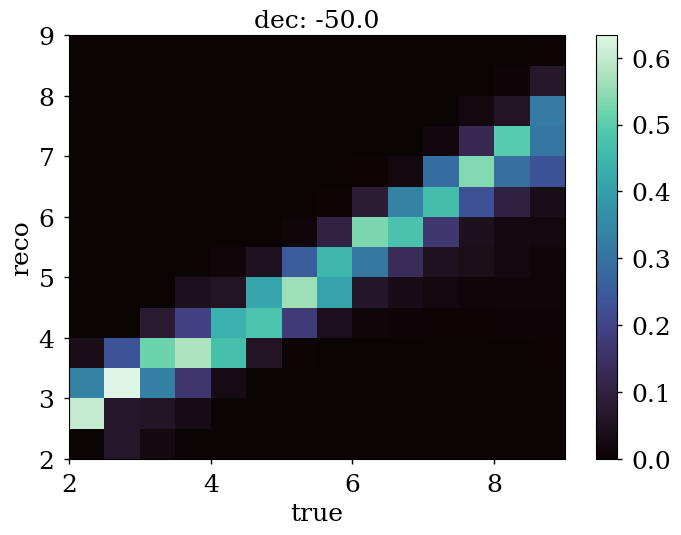

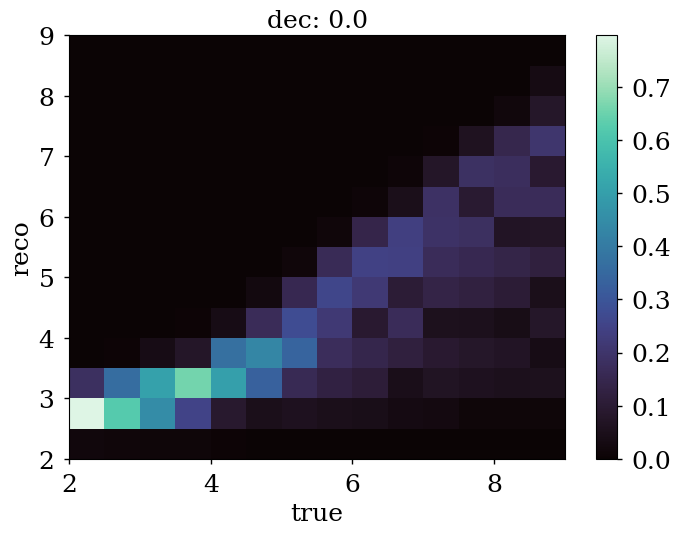

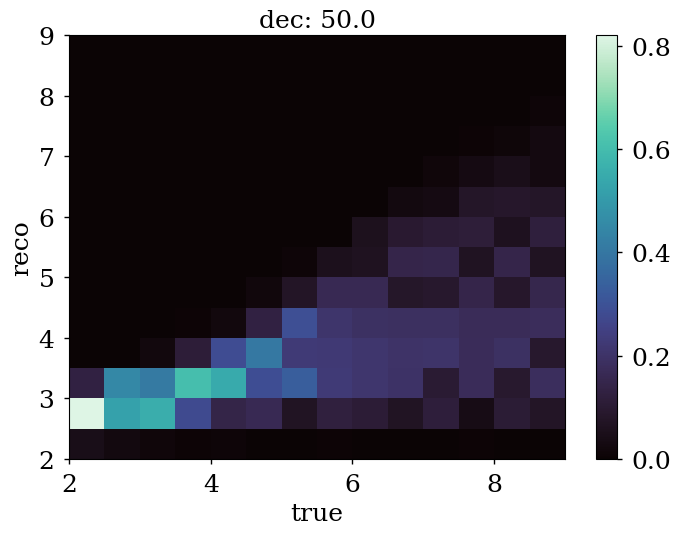

In [19]:
ebins = np.sort(
    np.unique(
        np.concatenate([public_data_df["logE_nu_min"], public_data_df["logE_nu_max"]])
    )
)
erecobins = np.sort(
    np.unique(
        np.concatenate([public_data_df["logE_reco_min"], public_data_df["logE_reco_max"]])
    )
)
# loop over declination bins
for dd in np.unique(dec_sm_mids):
    dec_mask = dec_sm_mids == dd
    # energy resolution per declination bin
    plt.figure()
    plt.title(f"dec: {dd}")
    plt.hist2d(
        log_sm_emids[dec_mask],
        log_sm_ereco_mids[dec_mask],
        weights=fractional_event_counts[dec_mask],
        bins=(ebins, ebins),
    )
    plt.xlabel("true")
    plt.ylabel("reco")
    plt.colorbar()

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

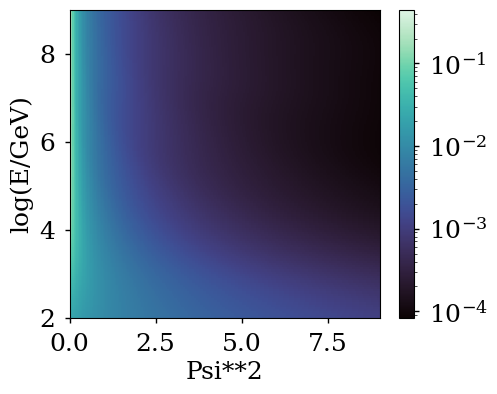

In [20]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
# select only horizontal resolution for NGC 1068 at horizon
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

e_psi2_grid.plot(norm=LogNorm())

# Flux definition

In [21]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 source parameters

In [22]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11

# 10yr PS paper (data release)
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(join(LOCALPATH, "tenyr_paper_68_contour.txt"))
phi_c_68_prev *= 1E-3

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [23]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know



In [24]:
from likelihood import ps_llh_multi, ps_llh_single, setup_multi_llh

In [25]:
def ps_llh_data(
    x,
    aeff_factor_s,
    background,
    k_i,
    energy_resolution,
    e_0,
    phi_0,
    shape,
    verbose=False,
):

    # background from data
    mu_b = background * x[0]

    # Calculate the signal contribution
    mu_s = astro_flux(
        aeff_factor_s,
        10 ** aeff_factor_s.bin_mids[1],
        energy_resolution,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        # Print additional information if verbose mode is enabled
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))

    # Calculate the total expected events for the Poisson LLH
    mu_i = mu_s + mu_b

    # Calculate -2 * log-likelihood using Poisson statistics
    return poisson_llh(mu_i, k_i)


# Asimov data

In [26]:
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_e,
    ) = setup_multi_llh(
        eres=baseline_eres,
        conf=conf,
        aeff_2d=aeff_2d,
        src_flux=ngc_flux,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_e,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the code
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.06719813]
Signal fit parameters: [1.  1.  3.2]
TS check: -297352.1893217332 (fit:  -297352.1893217332 )
-2 Delta LLH: 19.99655529728625
P-VALUE: 4.547819177110471e-05 SIGNIFICANCE: 3.91353055893947

Plenum-1
Atmo-only normalization: [1.09207985]
Signal fit parameters: [1.  1.  3.2]
TS check: -1332932.1992101008 (fit:  -1332932.1992101008 )
-2 Delta LLH: 113.03414660110138
P-VALUE: 2.850669914278596e-25 SIGNIFICANCE: 10.3203525930946

Plenum-2
Atmo-only normalization: [1.07517846]
Signal fit parameters: [1.  1.  3.2]
TS check: -1290935.375730374 (fit:  -1290935.375730374 )
-2 Delta LLH: 244.5793700153008
P-VALUE: 7.767202135625038e-54 SIGNIFICANCE: 15.403375513051868



# real data
## plotting

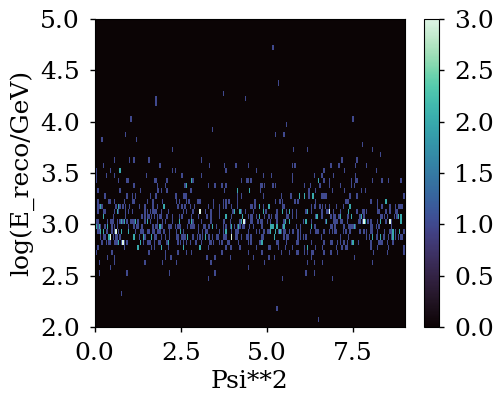

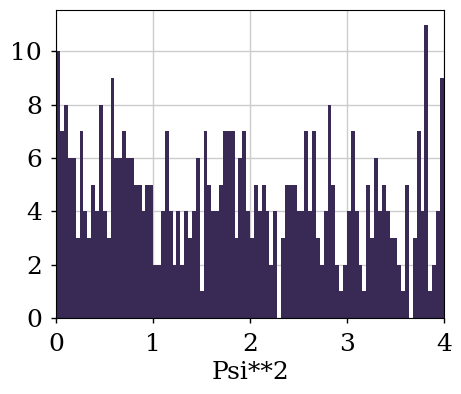

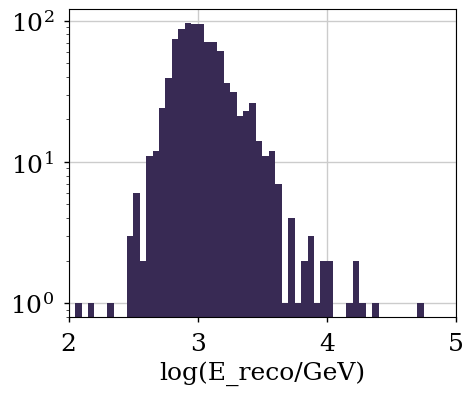

In [27]:
data_hist = mephisto.Mephistogram(
    (ngc_angular_distances**2, ngc_events["log10EGeV"]),
    bins=all_k[0].bins,
    axis_names=all_k[0].axis_names,
    make_hist=True
)

data_hist.plot()
plt.ylim(2, 5)

data_hist.sum(axis=1, return_mephisto=True).plot()
plt.gca().set_xlim(0, 4)
data_hist.sum(axis=0, return_mephisto=True).plot()

plt.xlim(2, 5)
plt.gca().set_yscale("log")


(2.0, 5.0)

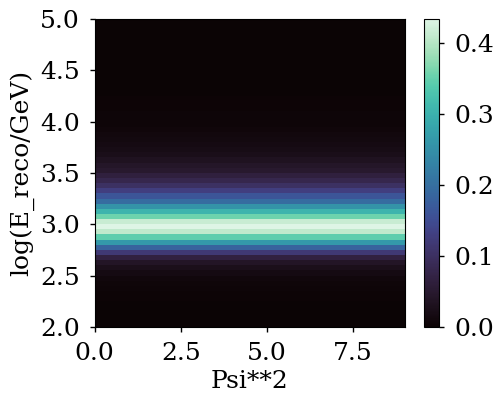

In [28]:
# make the background PDF from data
# use the energy distribution for one axis...
data_bg_hist, _ = np.histogram(ngc_dec_events["log10EGeV"], bins=logE_reco_bins)

# ... and a uniform distribution for the angular distance axis
data_bg = mephisto.Mephistogram(
    np.tile(data_bg_hist, len(psi2_mids)).reshape(data_hist.shape),
    bins=data_hist.bins,
    axis_names=data_hist.axis_names,
    make_hist=False,
)
# normalize such that it matches the data
# then the BG normalization will be close to 1 in the fit
data_bg.normalize(mode="full")
data_bg *= data_hist.sum()
data_bg.plot()
plt.ylim(2, 5)


In [29]:
bg_from_data = True

## analysis - point source

Atmo-only normalization: [1.00000005]
Signal fit parameters: [0.93204454 0.7401632  3.26188143]
P-VALUE:3.22e-04 SIGNIFICANCE: 3.4125704022427437


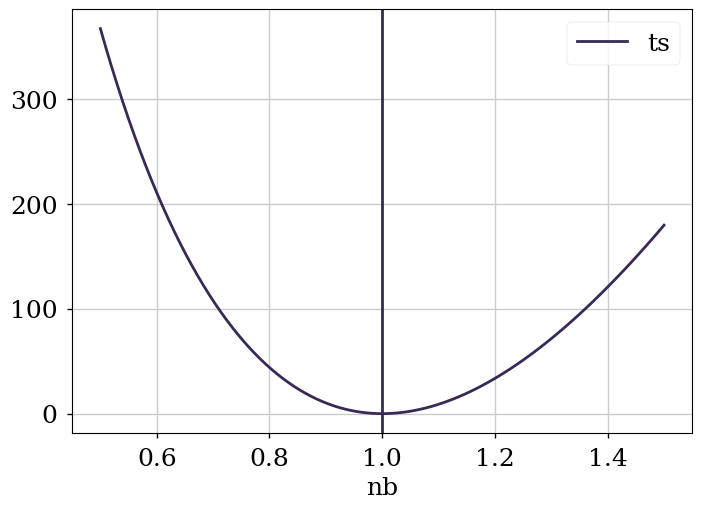

In [30]:
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###
if bg_from_data:
    k_b = data_bg
else:
    k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(
        ngc_src_config["dec"], bckg_histo["IceCube"], sindec_mids, axis=1
    ),
    energy_resolution=baseline_eres,
    )

dct = dict(
    shape="powerlaw",
    background=k_b,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
)

bg_llh = lambda x: ps_llh_data((x[0], 0, 3), **dct)

out_bckg = fmin_l_bfgs_b(
    bg_llh,
    x0=(1.1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# make parameter scans as crosscheck
# background-only scan
bg_ts = []
for nb in np.linspace(0.5, 1.5, 100):
    bg_ts.append({"ts": ps_llh_data((nb, 0, 3), **dct) - out_bckg[1], "nb": nb})

bg_ts = pd.DataFrame(bg_ts)
bg_ts.plot(x="nb", y="ts")
plt.axvline(out_bckg[0])

# full optimization of all parameters

global_llh = lambda x: ps_llh_data(x, **dct)

# S+B fit
out_global = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
    approx_grad=True,
)
print("Signal fit parameters:", out_global[0])

# significance
pval = chi2.sf(out_bckg[1] - out_global[1], 2)
significance = norm.isf(pval)
print(f"P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)


### data PDF agreement

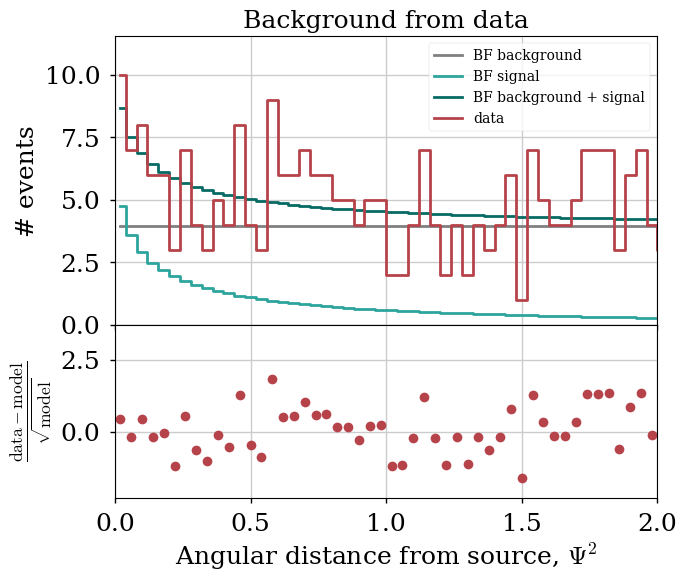

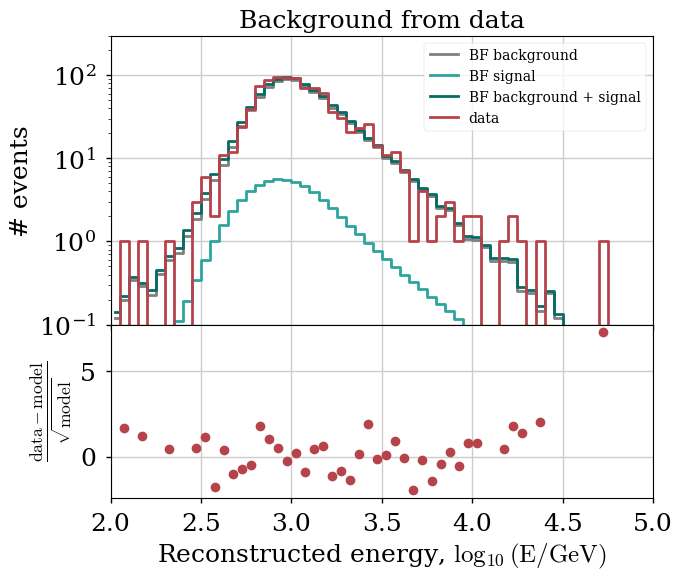

In [31]:
# compare psi and energy histograms of data and best-fit
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

# asimov data with baseline fluxes
if bg_from_data:
    k_b = data_bg * out_global[0][0]
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg * out_global[0][0],
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )

bf_ngc_flux = PL_flux(PHI_NGC * out_global[0][1], out_global[0][2], E0_NGC, "powerlaw")
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=bf_ngc_flux,  # powerlaw
)

k_sum_bf = k_s + k_b

if bg_from_data:
    title_str = "Background from data"
    save_str = "../../plots/ngc_paper/data-model_{}_dataBG.pdf"
else:
    title_str = "Background from MCEq"
    save_str = "../../plots/ngc_paper/data-model_{}_mceqBG.pdf"

# plot data and baseline flux comparison -- Psi**2
f, axes = plt.subplots(
    nrows=2,
    figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 3], "hspace": 0.0},
)
axes[0].set_title(title_str)
axes[0].plot(
    k_b.bin_mids[0],
    k_b.sum(axis=1),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

axes[0].plot(
    k_s.bin_mids[0], k_s.sum(axis=1), ds="steps-mid", label="BF signal", color=colors[1]
)

axes[0].plot(
    k_sum_bf.bin_mids[0],
    k_sum_bf.sum(axis=1),
    ds="steps-mid",
    label="BF background + signal",
    color=colors[2],
)
axes[0].plot(
    data_hist.bin_mids[0],
    data_hist.sum(axis=1),
    ds="steps-mid",
    label="data",
    color=colors[3],
)
plt.xlabel(r"Angular distance from source, $\Psi^2$")
plt.xlim(0, 2)

axes[1].plot(
    data_hist.bin_mids[0],
    (data_hist.sum(axis=1) - k_sum_bf.sum(axis=1)) / np.sqrt(k_sum_bf.sum(axis=1)),
    lw=0,
    marker="o",
    color=colors[3],
)
axes[1].set_ylabel(r"$\rm \frac{data - model}{\sqrt{model}}$")

axes[0].set_ylabel("# events")
axes[0].set_ylim(0, None)
axes[0].legend(loc=0, fontsize="medium")
f.savefig(save_str.format("psi"))

# plot data and baseline flux comparison -- energy
f, axes = plt.subplots(
    nrows=2,
    figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [5, 3], "hspace": 0.0},
)
axes[0].set_title(title_str)
axes[0].plot(
    k_b.bin_mids[1],
    k_b.sum(axis=0),
    ds="steps-mid",
    label="BF background",
    color="gray",
)

axes[0].plot(
    k_s.bin_mids[1], k_s.sum(axis=0), ds="steps-mid", label="BF signal", color=colors[1]
)

axes[0].plot(
    k_sum_bf.bin_mids[1],
    k_sum_bf.sum(axis=0),
    ds="steps-mid",
    label="BF background + signal",
    color=colors[2],
)
axes[0].plot(
    data_hist.bin_mids[1],
    data_hist.sum(axis=0),
    ds="steps-mid",
    label="data",
    color=colors[3],
)
plt.xlim(2, 5)
axes[0].legend(loc=0, fontsize="medium")
axes[0].set_yscale("log")
axes[0].set_ylim(1e-1, 3e2)
plt.xlabel(r"Reconstructed energy, $\rm \log_{10}(E/GeV)$")
axes[0].set_ylabel("# events")
mask = data_hist.sum(axis=0) > 0
axes[1].plot(
    data_hist.bin_mids[1][mask],
    ((data_hist.sum(axis=0) - k_sum_bf.sum(axis=0)) / np.sqrt(k_sum_bf.sum(axis=0)))[
        mask
    ],
    lw=0,
    marker="o",
    color=colors[3],
)
axes[1].set_ylabel(r"$\rm \frac{data - model}{\sqrt{model}}$")
#axes[1].set_ylim(-1.5, 6)
f.savefig(save_str.format("energy"))

### profile likelihood 
Contour -> optimize nb on a gamma-ns grid
Also, cross-check the BF results for the Global LLH


In [32]:
ident = "IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###
if bg_from_data:
    k_b = data_bg
else:
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(
        ngc_src_config["dec"], bckg_histo["IceCube"], sindec_mids, axis=1
    ),
    energy_resolution=baseline_eres,
    )
dct = dict(
    shape="powerlaw",
    background=k_b,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
)

sig_ts = []
num = 30
g_space = np.linspace(2.45, 4.2, num=num+1)
ns_space = np.logspace(-0.9, 0.2, num=num)

for g, s in product(g_space, ns_space):
    tmp = {}
    tmp["ns"] = s
    tmp["gamma"] = g

    _llh = lambda x: ps_llh_data((x[0], s, g), **dct)

    # S+B fit
    out_profile = fmin_l_bfgs_b(
        _llh,
        x0=(1, ),
        bounds=[(1E-3, 10),],
        approx_grad=True,
    )

    tmp["ts"] = out_profile[1]
    tmp["delta_ts"] = out_profile[1] - out_global[1]
    tmp["nb"] = out_profile[0][0]
    sig_ts.append(tmp)

sig_ts = pd.DataFrame(sig_ts)

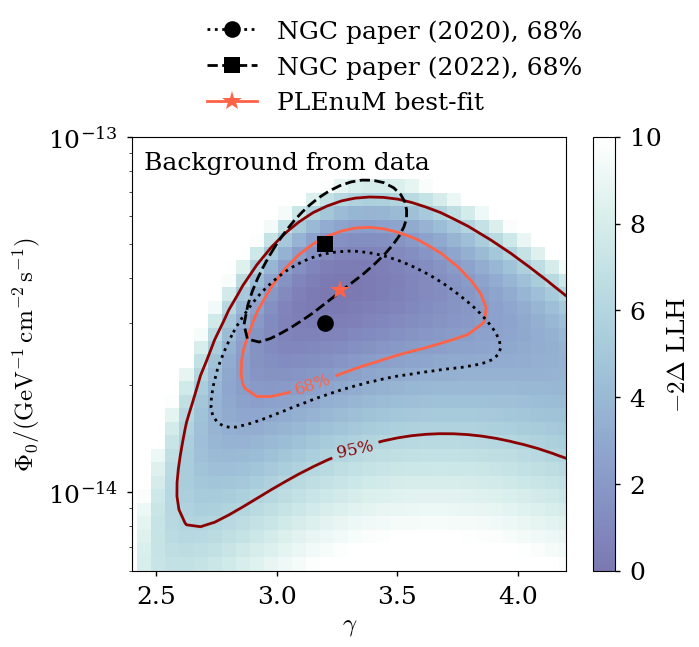

In [54]:
sig_ts["norm"] = sig_ts["ns"] * ngc_flux.norm
sig_ts_piv = sig_ts.pivot(index="norm", columns="gamma", values="delta_ts")
cvals = [0.32, 0.05]
lbs = ["68%", "95%"]
levels = chi2.isf(cvals, 2)
cur_cmap = sns.cubehelix_palette(
    start=0.75, rot=-0.5, light=1, dark=0.5, as_cmap=True, reverse=True
)
f, ax = plt.subplots(figsize=(7, 7))
plt.pcolormesh(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    vmin=0,
    vmax=10,
    cmap=cur_cmap,
    # alpha=0.5,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar()
cb.set_label(r"$-2 \Delta$ LLH")

plt.plot(gamma_c_68_prev, phi_c_68_prev, color="k", ls=":")
plt.plot(
    3.2,
    3e-14,
    color="k",
    marker="o",
    label="NGC paper (2020), 68%",
    ms=12,
    ls=":",
)

plt.plot(gamma_c_68, phi_c_68 * 1e-3, color="k", ls="--")
plt.plot(
    3.2,
    5e-14,
    color="k",
    marker="s",
    label="NGC paper (2022), 68%",
    ms=12,
    ls="--",
)


plt.plot(
    out_global[0][2],
    out_global[0][1] * ngc_flux.norm,
    color="tomato",
    marker="*",
    ms=15,
    label="PLEnuM best-fit",
)
sc = plt.contour(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    levels=levels,
    lw=3,
    colors=["tomato", "darkred"],zorder=1
)

fmt = {l: s for l, s in zip(sc.levels, lbs)}
plt.clabel(sc, levels, fmt=fmt, fontsize=12)


plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\Phi_0 / ({\rm GeV^{-1}\, cm^{-2}\, s^{-1}})$")
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.5, 0.93),
)
if bg_from_data:
    title_str = "Background from data"
    save_str = "../../plots/ngc_paper/experimental_data_2Dscan.pdf"
else:
    title_str = "Background from MCEq"
    save_str = "../../plots/ngc_paper/experimental_data_2Dscan_MCEq.pdf"
plt.text(2.45, 8.1e-14, title_str, fontsize=18)
plt.yscale("log")
plt.ylim(6e-15, 1e-13)
# plt.ylim(0, 1e-13)
plt.grid(False)

plt.xlim(2.4, 4.2)
f.subplots_adjust(top=0.73)
f.savefig(save_str)

## analysis - spectral fit


Atmo-only normalization: [1.00000005]
PL Signal fit parameters: [0.93204454 0.7401632  3.26188143]
P-VALUE:3.22e-04 SIGNIFICANCE: 3.4125704022427437
PLC Signal fit parameters: [0.93215368 0.74029117 3.25296373 6.14073915]
P-VALUE:9.56e-01 SIGNIFICANCE: -1.7109676401842275


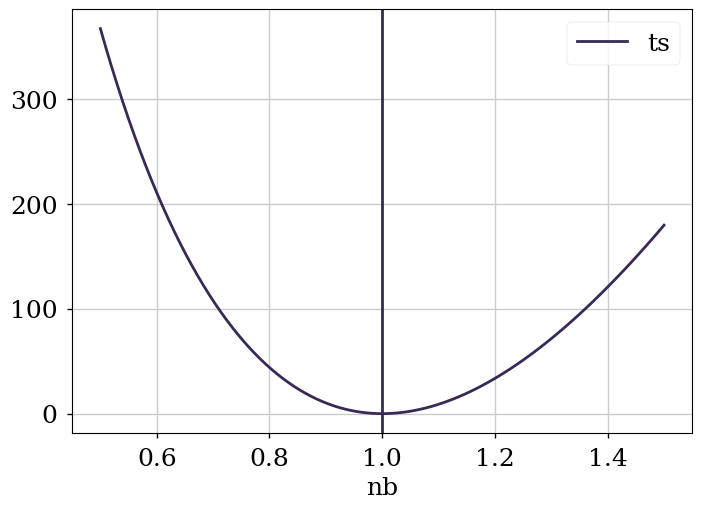

In [42]:
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
# asimov data with baseline fluxes

### we use the bg from data instead! ###
if bg_from_data:
    k_b = data_bg
else:
    k_b = atmo_background(
        aeff_factor=aeff_factor_bckg,
        bckg_vals=array_source_interp(
            ngc_src_config["dec"], bckg_histo["IceCube"], sindec_mids, axis=1
        ),
        energy_resolution=baseline_eres,
    )

dct = dict(
    shape="powerlaw",
    background=k_b,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
)

bg_llh = lambda x: ps_llh_data((x[0], 0, 3), **dct)

out_bckg = fmin_l_bfgs_b(
    bg_llh,
    x0=(1.1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# make parameter scans as crosscheck
# background-only scan
bg_ts = []
for nb in np.linspace(0.5, 1.5, 100):
    bg_ts.append({"ts": ps_llh_data((nb, 0, 3), **dct) - out_bckg[1], "nb": nb})

bg_ts = pd.DataFrame(bg_ts)
bg_ts.plot(x="nb", y="ts")
plt.axvline(out_bckg[0])

# full optimization of all parameters of PL model

pl_llh = lambda x: ps_llh_data(x, **dct)

# S+B fit
out_global = fmin_l_bfgs_b(
    pl_llh,
    x0=(1, 1, ngc_flux.gamma),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
    approx_grad=True,
)
print("PL Signal fit parameters:", out_global[0])

# significance
pval = chi2.sf(out_bckg[1] - out_global[1], 2)
significance = norm.isf(pval)
print(f"P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)

# full optimization of all parameters of PLC model
dct.pop("shape")
plc_llh = lambda x: ps_llh_data(x, shape="powerlaw with cutoff", **dct)

# S+B fit
out_global_plc = fmin_l_bfgs_b(
    plc_llh,
    x0=(1.2, 1.1, 1.9, 3.4),
    bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10), (1e-1, 15)],
    approx_grad=True,
)
print("PLC Signal fit parameters:", out_global_plc[0])

# significance
pval = chi2.sf(out_global[1] - out_global_plc[1], 1)
significance = norm.isf(pval)
print(f"P-VALUE:{pval:1.2e}", "SIGNIFICANCE:", significance)


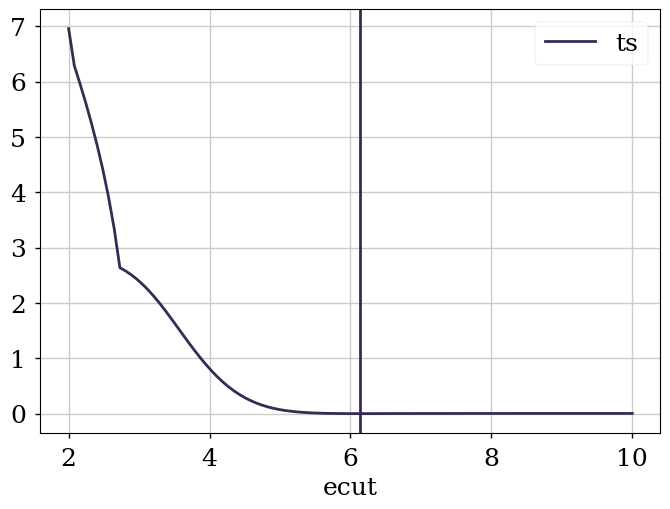

In [52]:

# make parameter scans as crosscheck
# cutoff-energy scan
plc_ts = []

dct = dict(
    shape="powerlaw with cutoff",
    background=k_b,  # we use the bg from data instead!
    aeff_factor_s=aeff_factor_signal,
    k_i=data_hist,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
)

for ecut in np.linspace(2, 10, 100):
    plc_llh_local = lambda x: ps_llh_data(
        (x[0], x[1], x[2], ecut), **dct
    )
    plc_ts.append(
        {
            "llh": fmin_l_bfgs_b(
                plc_llh_local,
                x0=(1.2, 1.1, 1.9),
                bounds=[(1e-3, 10), (1e-3, 10), (1e-3, 10)],
                approx_grad=True,
            )[1],
            "ecut": ecut,
        }
    )

plc_ts = pd.DataFrame(plc_ts)
plc_ts["ts"] = plc_ts["llh"] - plc_ts["llh"].min()
plc_ts.plot(x="ecut", y="ts")
plt.axvline(out_global_plc[0][-1])